## Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation
from tqdm import tqdm

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device, max_size=500):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = th.sigmoid(self.l4(a))
        return 1.8 * a + 0.2 # scale to [0.2, 2.0]

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

In [ ]:
# Define DDPG Agent
class DDPGAgent(object):
    def __init__(self, env, device, discount=0.9, tau=0.01):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(self.state_dim, self.action_dim).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(self.state_dim, self.action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=1e-4)
        self.critic_target = deepcopy(self.critic)
        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, self.device)

    def soft_update(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, state): # Actor selects action based on current state
        return self.actor(th.tensor(state, dtype=th.float32).to(self.device)).detach().cpu().numpy()

    def train(self, batch_size=32, target_update_period=10, max_iter=1000, max_patience=50):
        CHO_idx = int(2*self.state_dim/3 - 1)
        critic_training_loss = []
        min_critic_loss = float('inf')
        patience = max_patience
        for it in tqdm(range(max_iter)):
            print('Why am I not working?')
            # Sample one episode and add it to the replay buffer
            state, info = self.env.reset()
            reset_time = info['time']
            done = False
            last_meal = state[CHO_idx]
            while not done and (info['time'] - reset_time).seconds < 4*24*3600: # 4 days
                if last_meal > state[CHO_idx]: # First step after meal
                    print('Bolus Injection!')
                    start_state = state
                    start_time = info['time']
                    noise = np.random.normal(0, 0.3, (3,))
                    action = self.select_action(start_state) + noise
                    state, reward, done, _, info = self.env.step(action)
                    reward_sum = reward
                    while not done and state[CHO_idx] == 0 and (info['time'] - start_time).seconds < 5*3600:
                        action = [0, 0, 0]
                        state, reward, done, _, info = self.env.step(action)
                        reward_sum += reward
                    reward_sum /= (info['time'] - start_time).seconds / 60
                    next_state = state
                    self.replay_buffer.store(start_state, action, reward_sum, next_state, done)
                    print(f'Episode (reward: {reward_sum}) stored to memory ({self.replay_buffer.size})')
 
                else:
                    print('No bolus injection!')
                    action = [0, 0, 0]
                    state, _, done, _, info = self.env.step(action)

                last_meal = state[CHO_idx]
            
            if self.replay_buffer.size >= batch_size:
                print('TRAINING')
                # Sample replay buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                # Compute the target Q value
                target_q = self.critic_target(next_states, self.actor_target(next_states))
                target_q = rewards + (self.discount * target_q).detach()
                # target_q = rewards + ((not dones) * self.discount * target_q).detach() # XXX: ?????????????
                # Get current Q estimate
                current_q = self.critic(states, actions)
                # Compute critic loss
                critic_loss = F.mse_loss(current_q, target_q)
                # Optimize the critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                # Compute actor loss
                actor_loss = -self.critic(states, self.actor(states)).mean()
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                # Save training loss   
                if critic_loss < min_critic_loss:
                    min_critic_loss = critic_loss
                    patience = max_patience
                critic_training_loss.append([critic_loss.item(), actor_loss.item()])
                
                # Update target networks
                if it % target_update_period == 0:
                    self.soft_update()

                if it % 5 == 0:
                    print(f'Iteration: {it+1}, Critic loss: {critic_loss.item():.3f} (min: {min_critic_loss:.3f}), Patience left: {patience}')

                # Convergence check
                patience -= 1
                if patience == 0:
                    print('Critic converged...')
                    break

        return critic_training_loss

In [5]:
# Define reward function based on paper
def custom_reward(BG_history):
    BG = BG_history[-1]
    # BG: blood glucose level
    # Hypoglycemia: BG < 70 mg/dL
    if 30 <= BG and BG < 70:
        return -1.5
    # Normoglycemia: 70 mg/dL < BG < 180 mg/dL
    elif 70 <= BG and BG <= 180:
        return 0.5
    # Hyperglycemia: BG > 180 mg/dL
    elif 180 < BG and BG <= 300:
        return -0.8
    elif 300 < BG and BG <= 350:
        return -1
    # Other cases
    else:
        return -2

### Linking the DDPG agent to the OpenAI Gym environment

In [6]:
from simglucose.simulation.scenario_gen import RandomScenario

history_length = 6

gym.envs.register(
    id='simglucose-bolus',
    entry_point='simglucose.envs:T1DSimEnvBolus',
    kwargs={'patient_name': ['average_adolescent'],
        'history_length': history_length, 'reward_fun': custom_reward,
        'enable_meal': True})

In [7]:
env = gym.make('simglucose-bolus')
print(env.observation_space)
print(env.action_space)

Dict('CGM': Box(0.0, 10000.0, (6,), float32), 'CHO': Box(0.0, 10000.0, (6,), float32), 'insulin': Box(0.0, 10000.0, (6,), float32))
Box(0.2, 2.0, (3,), float32)


In [8]:
env = FlattenObservation(env)

In [11]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

agent = DDPGAgent(env=env, device=device)
critic_loss = agent.train()

100%|██████████| 1000/1000 [35:15<00:00,  2.12s/it] 


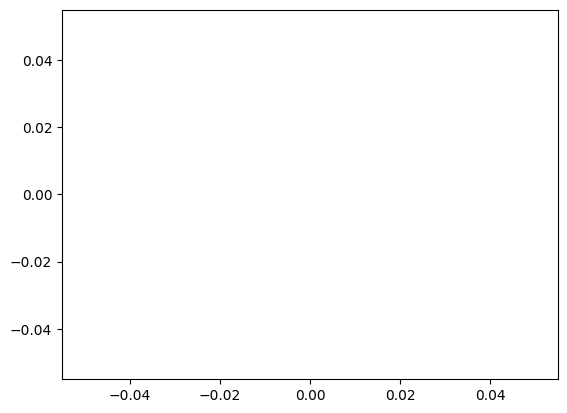

In [12]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in critic_loss])

info   {'time': datetime.datetime(2018, 1, 1, 8, 58), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 1), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 4), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 7), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 10), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 13), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 16), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
CHO    0.0
info   {'time': datetime.datetime(2018, 1, 1, 9, 19), 'meal': 0, 

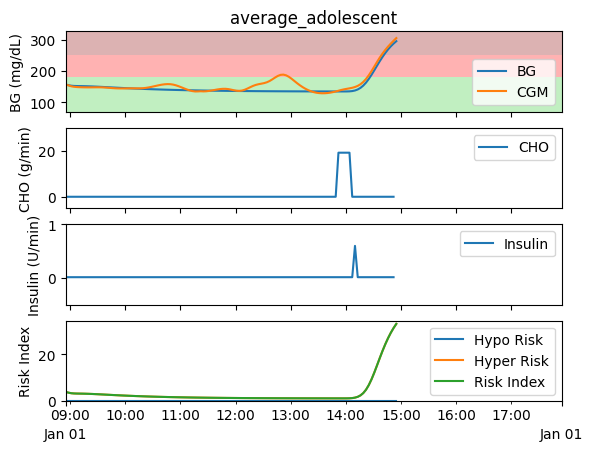

In [ ]:
observation, info = env.reset()
last_meal = 0
for t in range(1000):
    env.render(mode='human')
    if last_meal > observation[11]:
        print(observation)
        action = agent.select_action(observation)
        print('Bolus injection!')
        print(action)
    else:
        action = [0, 0, 0]
    last_meal = observation[11]
    observation, reward, done, _, info = env.step(action)  
    # print('info  ', info)     
    # print('CHO   ', observation[11])
    print(f'Still alive {t}', end='\r')
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))

        break